In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import Adam, RMSprop
from torchvision import transforms
import torchvision.transforms.functional as TF
from albumentations.pytorch import ToTensor
import albumentations as A
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os.path import join
import seaborn as sns
from collections import Counter
import pandas as pd
import os

from sklearn.metrics import (f1_score, 
                             recall_score,
                             balanced_accuracy_score,
                             precision_score, 
                             roc_auc_score, 
                             classification_report, 
                             confusion_matrix)   
               
from mlxtend.plotting import plot_confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def load_data(dir_path=None):
    class_1, class_0, target = [], [], []
    for filetype in FILETYPE:
        for filename in (filename for filename in os.listdir(join(dir_path, filetype)) if '.jpeg' in filename):
            image = cv2.imread(join(dir_path, filetype, filename))
            image = np.dstack([image]*3) if image.ndim==2 else image
            resized = cv2.resize(image, (224, 224))
            if filetype=="NORMAL":
                class_0.append(resized)
                target.append([1, 0])
            else:
                class_1.append(resized)
                target.append([0, 1])
                 
    return np.vstack([class_0, class_1]), np.array(target)

In [0]:
X_train = np.load('/content/drive/My Drive/data/images_arrays/train_images.npy')
X_test = np.load('/content/drive/My Drive/data/images_arrays/test_images.npy')
X_val = np.load('/content/drive/My Drive/data/images_arrays/val_images.npy')

y_train = np.load('/content/drive/My Drive/data/images_arrays/train_targets.npy')
y_val = np.load('/content/drive/My Drive/data/images_arrays/val_targets.npy')
y_test = np.load('/content/drive/My Drive/data/images_arrays/test_targets.npy')

In [0]:
def visualize_samples(images, rows=1, cols=5, title=None):
    plt.figure(figsize=(2.5*cols, 2.5*rows)).suptitle(title, size=15, color='black')
    idx = np.random.choice(images.shape[0], size=rows*cols)
    for i, sample in enumerate(images[idx]):
        plt.subplot(rows, cols, i+1)
        plt.axis('off')
        plt.imshow(sample)
    plt.show()

visualize_samples(X_train[y_train==0], rows=2, cols=6, title='NORMAL')
visualize_samples(X_train[y_train==1], rows=2, cols=6, title='PNEUMONIA')

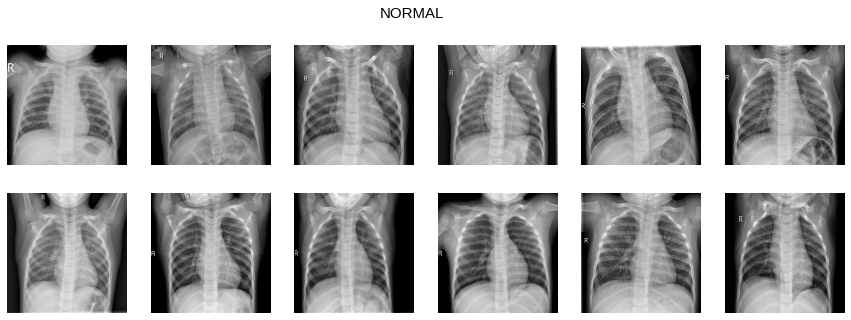

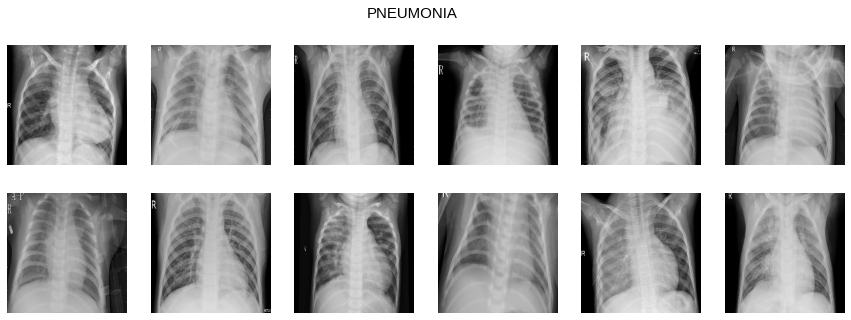

In [0]:
visualize_samples(X_train[y_train==0], rows=2, cols=6, title='NORMAL')
visualize_samples(X_train[y_train==1], rows=2, cols=6, title='PNEUMONIA')

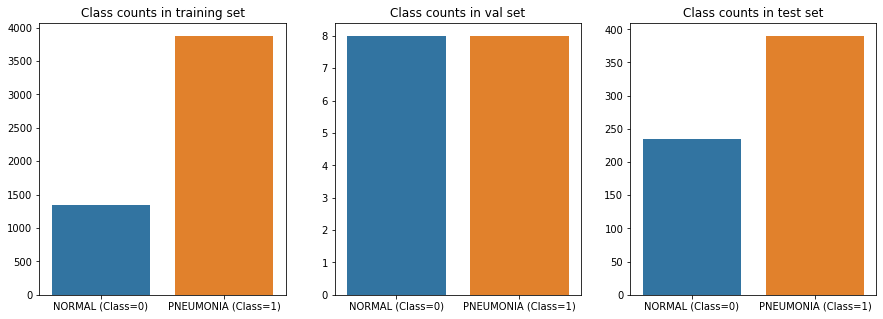

In [5]:
plt.figure(figsize=(15, 5))
for i, (labels, set_name) in enumerate(zip([y_train, y_val, y_test], ['training', 'val', 'test'])):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=['NORMAL (Class=0)', 'PNEUMONIA (Class=1)'], 
                y=list(Counter(labels).values()))
    plt.title("Class counts in {} set".format(set_name))
plt.show()

In [0]:
class TrainDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform 
    
    def __len__(self):
        return len(self.images)
  
    def __getitem__(self, index):
        image = self.images[index]
        image_tf = self.transform(image=image)['image']
        target = torch.tensor(self.labels[index], dtype=torch.long)
        return image_tf, target

In [0]:
aug_pipeline = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.OneOf([
        A.IAAAdditiveGaussianNoise(),
        A.GaussNoise(),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.2, 
                       rotate_limit=45, p=0.2),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=.1),
        A.IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    ToTensor(),
], p=.5)

In [0]:
traingen_params = dict(batch_size=32,
                       shuffle=True,
                       num_workers=6,
                       pin_memory=True)

valgen_params = dict(batch_size=6,
                     num_workers=6)


train_data = TrainDataset(images=X_train, labels=y_train, transform=aug_pipeline)
train_generator = DataLoader(train_data, **traingen_params)

val_data = TensorDataset(torch.tensor(X_val.transpose(0, 3, 2, 1) / 255., 
                                      dtype=torch.float), 
                                      torch.tensor(y_val, dtype=torch.long))
val_generator = DataLoader(val_data, **valgen_params)

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, groups=64, kernel_size=(3, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, groups=128, kernel_size=(3, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
      )
        self.dense_layers = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(7680, 1046),
            nn.ReLU(inplace=True),
            nn.Dropout(p=.3),
            nn.Linear(1046, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=.3),
            nn.Linear(256, 2)
      )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.dense_layers(x)
        return x

In [0]:
model = Network().to(device)
optimizer = Adam(model.parameters(), lr=0.001)
objective = nn.CrossEntropyLoss().to(device)

In [0]:
def visualize_results(train_loss, val_loss) :
    plt.figure(figsize=(5, 5))
    epochs = range(1, 1 + len(train_loss)) 
    plt.style.use('seaborn-white')
    plt.plot(epochs, train_loss, color='blue', label='Train loss')
    plt.plot(epochs, val_loss, color='orange', label='Valdation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


Epoch 1/20



	 train_loss: 0.3456 	
 	 val_loss: 1.2398 	

Epoch 2/20



	 train_loss: 0.2234 	
 	 val_loss: 1.6711 	

Epoch 3/20



	 train_loss: 0.1855 	
 	 val_loss: 1.7031 	

Epoch 4/20



	 train_loss: 0.1895 	
 	 val_loss: 1.4914 	

Epoch 5/20



	 train_loss: 0.1840 	
 	 val_loss: 1.5580 	

Epoch 6/20



	 train_loss: 0.1622 	
 	 val_loss: 1.7738 	

Epoch 7/20



	 train_loss: 0.1647 	
 	 val_loss: 1.8553 	

Epoch 8/20



	 train_loss: 0.1570 	
 	 val_loss: 1.5909 	

Epoch 9/20



	 train_loss: 0.1395 	
 	 val_loss: 1.6190 	

Epoch 10/20



	 train_loss: 0.1552 	
 	 val_loss: 1.5849 	

Epoch 11/20



	 train_loss: 0.1566 	
 	 val_loss: 1.7862 	

Epoch 12/20



	 train_loss: 0.1488 	
 	 val_loss: 1.6416 	

Epoch 13/20



	 train_loss: 0.1428 	
 	 val_loss: 1.5414 	

Epoch 14/20



	 train_loss: 0.1423 	
 	 val_loss: 1.6329 	

Epoch 15/20



	 train_loss: 0.1372 	
 	 val_loss: 1.4505 	

Epoch 16/20



	 train_loss: 0.1423 	
 	 val_loss: 1.3563 	

Epoch 17/20



	 train_loss: 0.1345 	
 	 val_loss: 1.3499 	

Epoch 18/20



	 train_loss: 0.1280 	
 	 val_loss: 1.3992 	

Epoch 19/20



	 train_loss: 0.1267 	
 	 val_loss: 1.3715 	

Epoch 20/20



	 train_loss: 0.1306 	
 	 val_loss: 1.5012 	


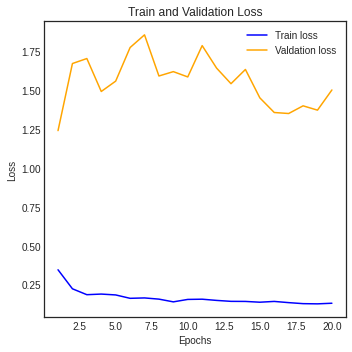

In [13]:
torch.manual_seed(0)
train_loss = []
val_loss = []
n_epochs = 20

for epoch in range(1, n_epochs+1):
    print('\nEpoch {}/{}'.format(epoch, n_epochs))
    training_loss = []
    validation_loss = []
    
    for batch_x, batch_y in tqdm(train_generator):
        train_x, train_y = batch_x.to(device), batch_y.to(device)
        outputs = model(train_x) # forward propagation
        loss = objective(outputs, train_y) # compute the loss
        training_loss.append(loss.item())
        loss.backward() # backpropagation 
        optimizer.step() # optimization step
        optimizer.zero_grad() # zero out the gradients
    
    with torch.set_grad_enabled(False):
        for val_batch_x, val_batch_y in val_generator:
            val_x, val_y = val_batch_x.to(device), val_batch_y.to(device)
            val_outputs = model(val_x)
            loss_val = objective(val_outputs, val_y)
            validation_loss.append(loss_val.item())

    training_loss = np.average(training_loss)
    validation_loss = np.average(validation_loss)
    train_loss.append(training_loss)
    val_loss.append(validation_loss)
    print('\t train_loss: %.4f \t\n' % training_loss, '\t val_loss: %.4f \t' % validation_loss)
visualize_results(train_loss, val_loss)

In [0]:
torch.save(model.state_dict(), '/content/drive/My Drive/models/saved_models_1.pkl')

In [0]:
X_test_tensor = torch.tensor((X_test.transpose(0, 3, 2, 1) / 255.), 
                             dtype=torch.float, 
                             device=device)
raw_predictions = model(X_test_tensor)
predict_prob = F.softmax(raw_predictions, dim=1)
pred_array = predict_prob.to('cpu').detach().numpy()
pred = np.copy(pred_array)
pred[pred > 0.5] = 1.0
pred[pred < 0.5] = 0.0
pred_classes = np.argmax(pred, axis=-1)

<Figure size 432x288 with 0 Axes>

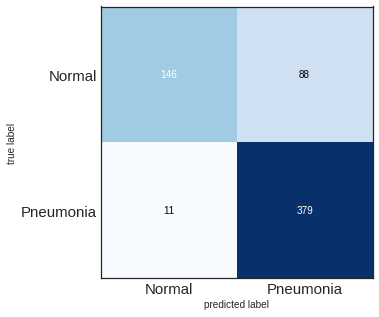

In [18]:
cm  = confusion_matrix(y_test, pred_classes)
plt.figure()
plot_confusion_matrix(cm,figsize=(15, 5), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=15)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=15)
plt.show()

In [21]:
f1score = f1_score(y_test, pred_classes)
rec = recall_score(y_test, pred_classes)
pre = precision_score(y_test, pred_classes) 
bal_acc = balanced_accuracy_score(y_test, pred_classes)
roc_auc = roc_auc_score(y_test, pred_classes)
scores = [f1score, roc_auc, rec, pre, bal_acc]

scoring_df = pd.DataFrame({'Metric' : ["F1-Score", "ROC AUC", "Recall", "Precision", "Balanced Acc"],
                           "Score": scores})

pd.options.display.float_format = '{:,.2f}'.format
scoring_df

,Metric,Score
0,F1-Score,0.88
1,ROC AUC,0.80
2,Recall,0.97
3,Precision,0.81
4,Balanced Acc,0.80
